In [1]:
from spectral_cube import SpectralCube #To read FITS
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from skimage import measure
from astropy import wcs
import cube_x3d as c3
import matplotlib.pyplot as plt
from matplotlib import cm
from astroquery.skyview import SkyView

In [3]:
import importlib
importlib.reload(c3)

<module 'cube_x3d' from 'c:\\Users\\ixaka\\Documents\\Visualization\\cube_x3d\\cube_x3d.py'>

In [2]:
%cd C:\Users\ixaka\Documents\Visualization

C:\Users\ixaka\Documents\Visualization


In [7]:
from astropy.io import fits

cube = fits.open('HCG31.fits')[0]
cube.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    4 / number of array dimensions                     
NAXIS1  =                  500                                                  
NAXIS2  =                  500                                                  
NAXIS3  =                  265                                                  
NAXIS4  =                    1                                                  
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BUNIT   = 'JY/BEAM '           / Units are in Jansky per beam                   
BMAJ    =  0.00856310736151017                                                  
BMIN    =  0.00680859418330118                                                  
BPA     =     154.7269825671

In [3]:
# Read the fits file and save header
cube = SpectralCube.read("HCG31.fits")
cubehead = cube.header
cubew = wcs.WCS(cubehead)
nz, ny, nx = cube.shape
print(cube.shape)
dra, ddec, dv = cubehead['CDELT1'], cubehead['CDELT2'], cubehead['CDELT3']
delta_arcsec = (np.abs(dra)*3600, np.abs(ddec)*3600, np.abs(dv))

(265, 500, 500)


In [33]:
# Read the fits file and save header
cube = SpectralCube.read("C:\\Users\\ixaka\\Documents\\Optical-Montoro\\flux_MRB_final_rss_subCube.fits")
cubehead = cube.header
cubew = wcs.WCS(cubehead)
nz, ny, nx = cube.shape
print(cube.shape)
dra, ddec, dv = cubehead['CDELT1'], cubehead['CDELT2'], cubehead['CDELT3']
delta_arcsec = (np.abs(dra)*3600, np.abs(ddec)*3600, np.abs(dv))

(682, 52, 58)


In [34]:
mask = SpectralCube.read('C:\\Users\\ixaka\\Documents\\Optical-Montoro\\flux_MRB_final_rss_subCube-mask.fits')

In [ ]:
#because the mask is for the full cube and we upload only the subcube, we need to cut the mask
minl = np.where(mask.spectral_axis == cube.spectral_axis[0])[0][0]
maxl = np.where(mask.spectral_axis == cube.spectral_axis[-1])[0][0]
print(mask.spectral_axis[[minl,maxl+1]])
print(cube.spectral_axis[[0,-1]])
mask = mask.unmasked_data[minl:maxl+1]

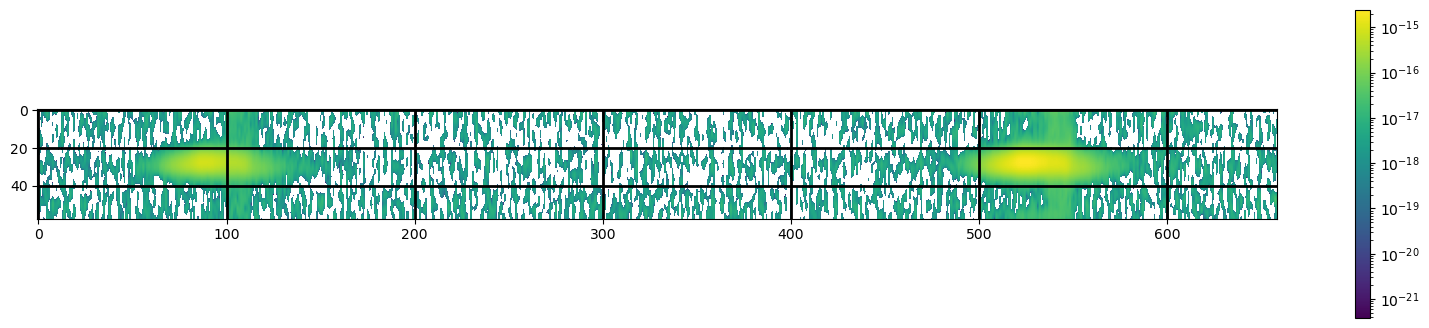

In [28]:
plt.figure(figsize=(20,4))
plt.imshow(cube.unmasked_data[3460:nz-181,25,].T, cmap='viridis', norm='log')
plt.grid(c='k', lw=2)
plt.colorbar()

(0.0, 2.6013794422907568e-15)

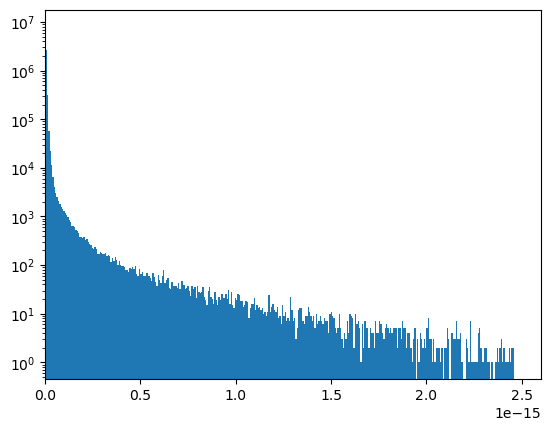

In [30]:
plt.hist(cube.unmasked_data[:].to_value().flatten(), bins=400)
plt.yscale('log')
plt.xlim(0,)

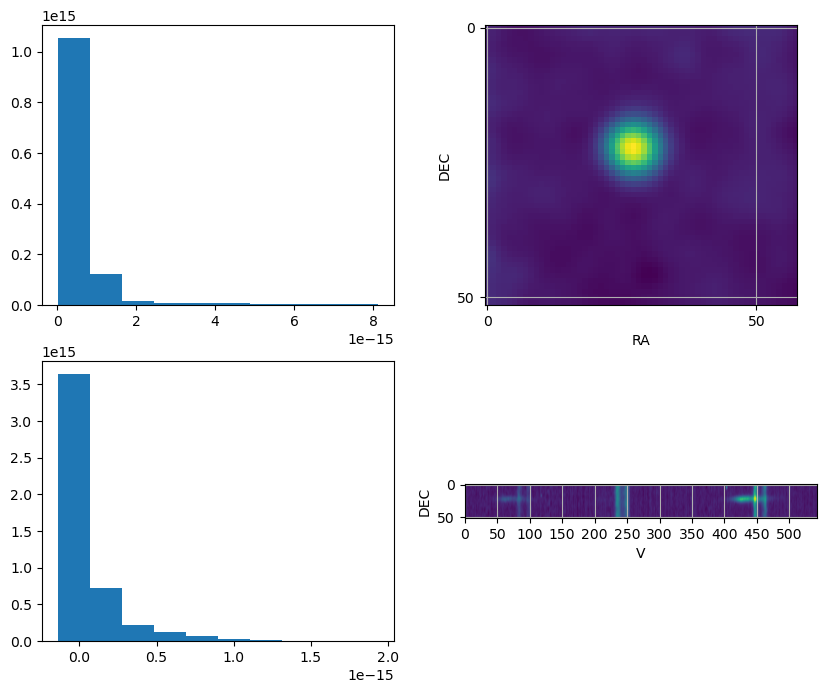

In [143]:
c3.preview2d(cube.unmasked_data[:].to_value())

In [2]:
import numpy as np
np.empty((3,2))

array([[2.49218658e-312, 4.77174042e-307],
       [3.38460885e+125, 3.38346180e-312],
       [3.49840714e-307, 1.33360329e+241]])

In [37]:
limx = [0, nx-1]
limy = [0, ny-1]
limz = [0, nz-1]

In [28]:
#borja MRB (don't use lims if reading subCube)
# Limits to crop the cube, no HI there. Subtract 1 to wanted number, e.g. nz-1.
limx = [0, nx-1]
limy = [0, ny-1]
limz = [3460, nz-181]

In [5]:
#borja HRR (don't use lims if reading subCube)
# Limits to crop the cube, no HI there. Subtract 1 to wanted number, e.g. nz-1.
limx = [0, nx-1]
limy = [0, ny-1]
limz = [1520, 2100-1] #also 4300-2200

In [38]:
ralim = cube.spatial_coordinate_map[1][0,:][limx][::int(np.sign(cubehead["CDELT1"]))]
ramean = np.mean(ralim)
declim = cube.spatial_coordinate_map[0][:,0][limy][::int(np.sign(cubehead["CDELT2"]))]
decmean = np.mean(declim)
vlim = cube.spectral_axis[limz][::int(np.sign(dv))]
vmean = np.mean(vlim).to('angstrom').to_value()

In [40]:
# with mask
cube = cube.unmasked_data[:] * mask.unmasked_data[:]/np.max(mask.unmasked_data[:])

In [136]:
# without mask
cube = cube.unmasked_data[:]

In [43]:
# create cropped array and transform units to mJy/beam
HI_cube = cube[limz[0]:limz[1]+1,limy[0]:limy[1]+1,limx[0]:limx[1]+1].to_value() *10**16 #*10**17 for HRR and *10**16 for MRB
# Slice the data, transpose to (ra,dec,v) and flip axes if needed (see if step in FITS header is + or -)
HI_cube = c3.transpose(HI_cube, (dra,ddec,dv))

(0.0, 25.832002612827726)

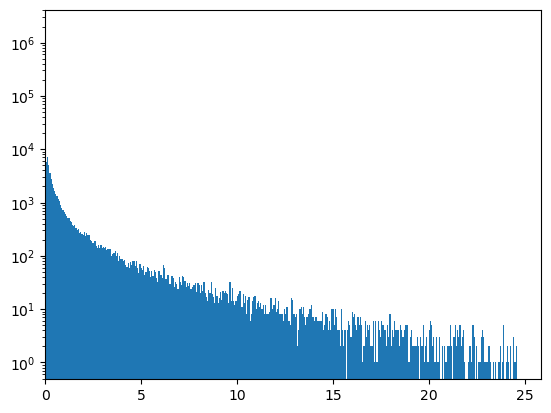

In [44]:
plt.hist(HI_cube.flatten(), bins=400)
plt.yscale('log')
#plt.ylim(0,5e3)
plt.xlim(0,)

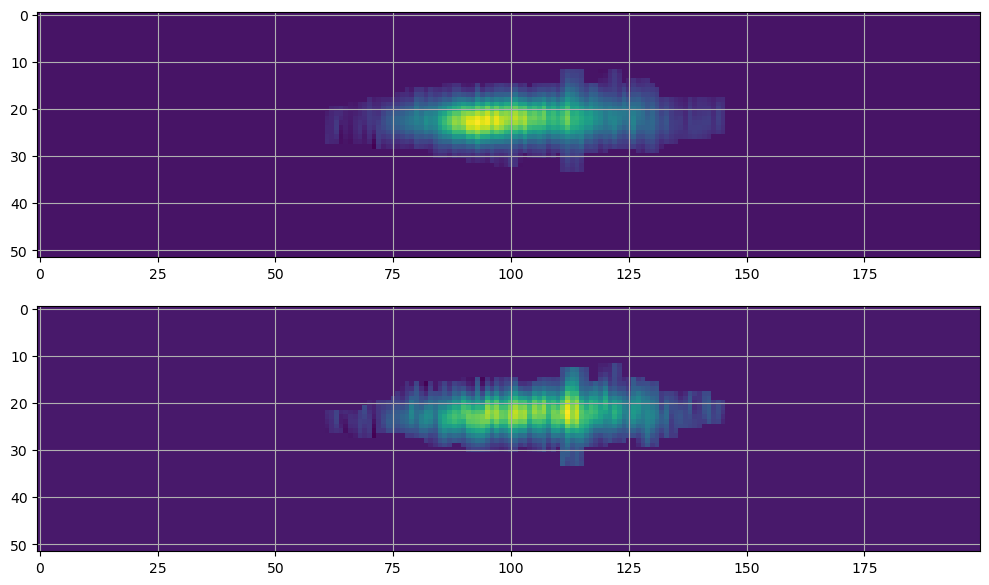

In [10]:
fig, ax = plt.subplots(nrows=2,figsize=(30,7))
ax[0].imshow(HI_cube[29,:,:200])
ax[0].grid()
ax[1].imshow(HI_cube[26,:,:200])
ax[1].grid()

In [45]:
#MRB
cube1 = np.empty(HI_cube.shape)
cube1[:,:,20:180] = HI_cube[:,:,20:180]
cube2 = np.empty(HI_cube.shape)
cube2[:,:,500:600] = HI_cube[:,:,500:600]
cubes = [cube1, cube2]

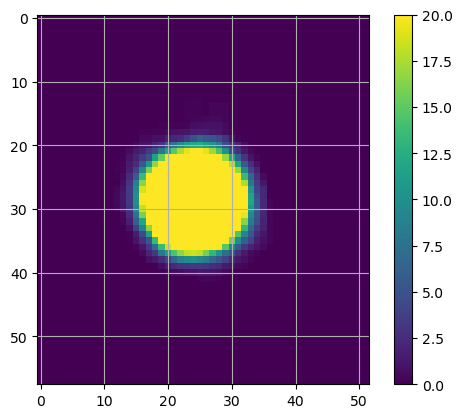

In [46]:
plt.imshow(np.sum(cube1, axis=2), vmin=0, vmax=20)
plt.grid()
plt.colorbar()

In [11]:
#HRR
cube1 = np.empty(HI_cube.shape) #NII
cube1[:,:,:200] = HI_cube[:,:,:200]
cube2 = np.empty(HI_cube.shape) #H-alpha
cube2[:,:,200:320] = HI_cube[:,:,200:320]
#cube3 = np.empty(HI_cube.shape) #nebula where H-alpha
#cube3[:,:,260:320] = HI_cube[:,:,260:320]
cube4 = np.empty(HI_cube.shape) #NII
cube4[:,:,350:] = HI_cube[:,:,350:]
cubes = [cube1, cube2, cube4]

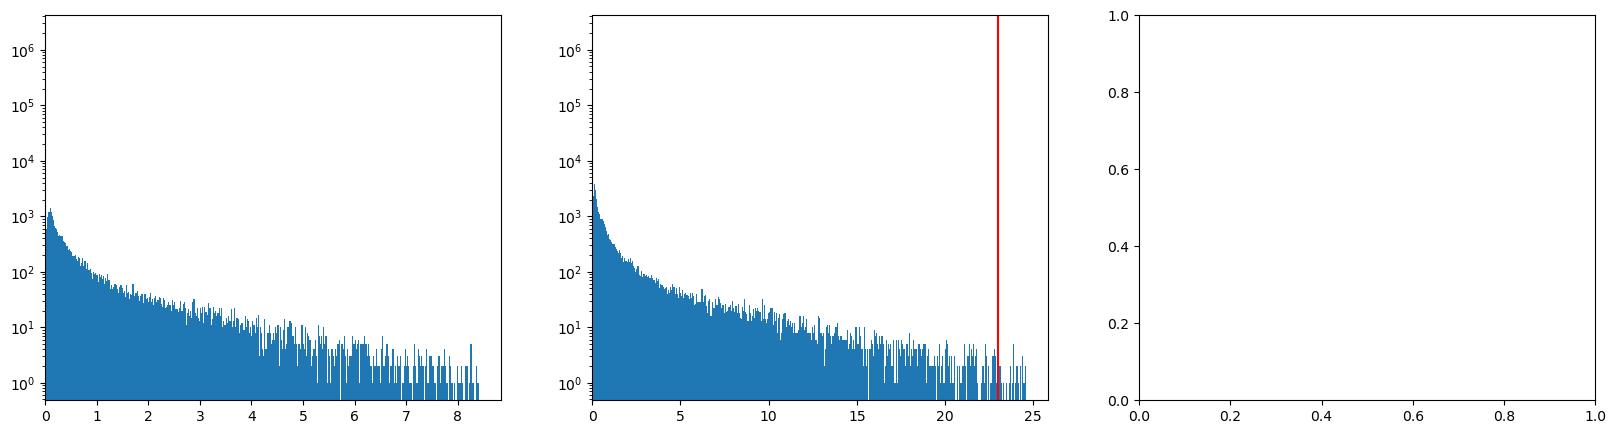

In [51]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))
ax[0].hist(cube1.flatten(), bins=400)
ax[0].set_yscale('log')
ax[0].set_xlim(0,)
ax[1].hist(cube2.flatten(), bins=400)
ax[1].set_yscale('log')
ax[1].set_xlim(0,)
ax[1].axvline(23, c='r')
#ax[2].hist(cube4.flatten(), bins=400)
#ax[2].set_yscale('log')
#ax[2].set_xlim(0,)

Seems that for HRR we can recognize where the nebula emission starts, from the gaussian at the beggining it comes up again at around 0.9.

In [52]:
#MRB
isolevels1 = np.array([0.45, 1.1, 2.3, 4, 6, 7])
isolevels2 = np.array([0.41, 1.1, 2, 5, 9, 13, 18, 23])
isolevels = [isolevels1, isolevels2]


In [13]:
#HRR
isolevels1 = np.array([1, 2, 3, 4])
isolevels2 = np.array([0.2, 0.35, 0.55, 0.7])
isolevels3 = np.array([1.2, 2.5, 4, 6, 9, 13])
isolevels = [isolevels1, isolevels2, isolevels3]

In [53]:
# Save new dimensions
nx_2, ny_2, nz_2 = HI_cube.shape
print(HI_cube.shape)

(58, 52, 682)


In [54]:
coords = np.array([ralim, declim, vlim])

In [55]:
color1 = c3.create_colormap('Blues', isolevels1)
color2 = c3.create_colormap('Reds', isolevels2)
#color3 = c3.create_colormap('Greens', isolevels3)
colors = [color1,color2] #,color3]

In [56]:
meta = {'generator':'create_x3d python module',
       'creator':'Name Surname',
       'title':cubehead['OBJECT'],
        'numberofelements':f'{len(isolevels)} layers',
        'description':'HI data cube of %s'%cubehead['OBJECT']
       }

In [57]:
x3dname = 'mrb_mask.x3d'

In [58]:
file = c3.write_x3d('./cube_x3d/examples/%s'%x3dname, delta_arcsec,
                    coords, header=cubehead, units=["e16 "+cubehead["BUNIT"], 'arcsec', 'arcsec', 'angstrom'], meta=meta, picking=False)

#also need html.func_pick() if picking=True

[[ -6.10790397   0.           6.10790397]
 [ -5.4672       0.           5.4672    ]
 [-37.455        0.          37.455     ]]


In [59]:
file.make_layers(cubes, isolevels, colors)
file.make_outline()
#file.make_galaxies(gals=gals, labels=True)
file.make_image2d(imcol=None, img_shape=None)
file.make_ticklines()
file.make_labels(gals=None, axlab='both') 
#html.func_scalev(axes) should be same as axlab, not func_axes() though.
file.close()

In [60]:
tabtitle = f'{cubehead["OBJECT"]}'
pagetitle = f'3D interactive datacube: {cubehead["OBJECT"]}'
# add in desc for 2d image: <br>\n\t Background image: {survey}
desc = f"Object: {cubehead['OBJECT']}.<t> Telescope: {cubehead['TELESCOP']}, Instrument: {cubehead['INSTRUME']}, Obsmode: {cubehead['OBSMODE']}.<br>\n\t Center: (RA,DEC, $\lambda$)=({np.round(ramean,5)} {cubehead['CUNIT1']}, {np.round(decmean,5)} {cubehead['CUNIT2']}, {np.round(vmean),2} {cubehead['CUNIT3']}). Date-obs: {cubehead['DATE-OBS']}"

In [61]:
colmaps = ['Blues', 'Reds', 'Greens', 'magma', 'CMRmap', 'inferno', 'plasma', 'viridis', 'Greys',
            'OrRd', 'PuRd', 'Spectral', 'Wistia',
          'YlGn', 'YlOrRd', 'afmhot', 'autumn', 'cool', 'coolwarm',
          'copper', 'cubehelix', 'flag', 'gist_earth', 'gist_heat',
          'gist_ncar', 'gist_stern', 'gnuplot', 'gnuplot2', 'hot',
          'nipy_spectral', 'prism', 'winter', 'Paired']

In [62]:
html = c3.write_html('./cube_x3d/examples/%s.html'%x3dname.split('.')[0], 
                    units=["e16 "+cubehead["BUNIT"], 'arcsec', 'arcsec', 'angstrom'],
                     tabtitle=tabtitle, pagetitle=pagetitle,
                     description=desc)

In [63]:
html.func_layers(isolevels)
#html.func_galaxies(gals)
#html.func_gallab()
html.func_grids()
html.func_axes('diff')
#html.func_pick() #for coordinate picking
html.start_x3d()
html.viewpoints(maxcoord=file.diff_coords[:,2])
html.close_x3d(x3dname)
#['NII ($6548.05 \, \mathring{A}$)', '$\mathbf{H \alpha}$ ($6562.75 \, \mathring{A}$)', 'NII ($6583.45 \, \mathring{A})$']
#['OIII ($4958.911 \, \mathring{A}$)', 'OIII ($5006.843 \, \mathring{A})$']
html.buttons(isolevels, l_colors=colors, colormaps=colmaps, hide2d=True, scalev=True, move2d=True, centRot=True, lineLabs=['OIII ($4958.911 \, \mathring{A}$)', 'OIII ($5006.843 \, \mathring{A})$'])
#func_move2dimage, func_setCenterOfRotation, func_colormaps and func_scalev must always go after buttons
html.func_image2d()
#['0 0 -29.3', '0 0 19.1'] for MRB
#['0 0 -19', '0 0 -4','0 0 17.5'] for HRR
html.func_setCenterOfRotation(['0 0 -29.3', '0 0 19.1'])
html.func_colormaps(isolevels)
html.func_scalev(gals=None, axes='diff', coords=file.diff_coords, vmax=file.diff_coords[2,2]) #file.diff_coords[2,2]
html.func_move2dimage(real_vmax=file.real_coords[2,2], diff_vmax=file.diff_coords[2,2])
html.close_html()